In [1]:
from seq_net import *
sess = tf.Session()
net = SeqNet(sess, seq_len=32)
%load_ext line_profiler

In [2]:
import os
import pickle

data = {}
for f in os.listdir('data/genes'):
    data[f[:-2]] = pickle.load(open('data/genes/' + f, 'rb'), encoding='latin1')
    
labels = [x for x in data]
testing = ['LCE6A','RCOR3','KLHL20','GPR137B','USH2A','SMYD3',
           'CNIH3','CFHR2','WDYHV1','OPN3','TNN',
           'CAMK1G','LENEP','CYB5R1','EPHX1']
training = [x for x in labels if x not in testing]

val = []
tran = []
times = []

In [ ]:
for x in data:
    print(x, len(data[x]))

In [ ]:
def get_time_top3():
    test_data = data[random.choice(testing)]

    s, a, r = net.path([(dna_vec(a), b) for a, b in test_data])
    top3 = sorted(test_data, key=lambda x: x[1])[-3:]

    for i, (state, action, reward) in enumerate(zip(s, a, r)):
        best_seen = state[-1]# max(state, key=lambda x: x[1])
        if vec_dna(best_seen[0]) in [x[0] for x in top3]:
            return i
    return 20


In [ ]:
from tqdm import trange
import random 
for i in trange(100):
    gene = random.choice(training)
    samples = [(dna_vec(a), b) for a, b in data[gene]]
    #%lprun -f SeqNet.multi_path net.train(samples, 10)
    tran.append(net.train(samples, 50))
    gene = random.choice(testing)
    samples = [(dna_vec(a), b) for a, b in data[gene]]
    times.append(get_time_top3())
    if i % 2 + 1:
        val.append(net.evaluate(samples, 10))
    else:
        val.append(val[-1])

In [8]:
# Save weights

saver = tf.train.Saver()
saver.save(net.sess, 'results/model.ckpt')

'results/model.ckpt'

In [3]:
# Load weights

saver = tf.train.Saver()
saver.restore(net.sess, 'results/model.ckpt')

INFO:tensorflow:Restoring parameters from results/model.ckpt


In [9]:
# Save training data

pickle.dump(val, open('results/validation.p', 'wb'))
pickle.dump(tran, open('results/training.p', 'wb'))
pickle.dump(times, open('results/times.p', 'wb'))

In [4]:
import pickle
# Load old data

val = pickle.load(open('results/validation.p', 'rb'))
tran = pickle.load(open('results/training.p', 'rb'))
times = pickle.load(open('results/times.p', 'rb'))

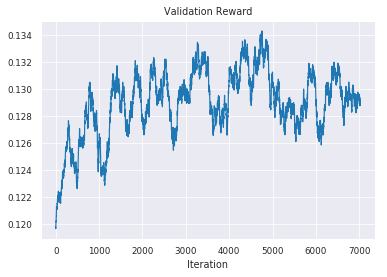

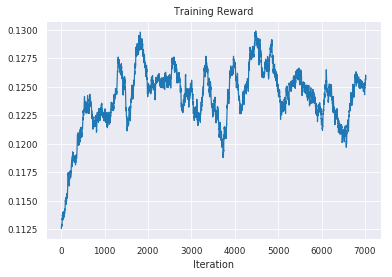

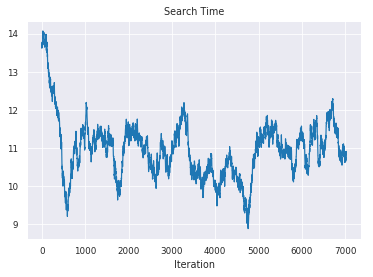

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style('darkgrid')
sns.set_context('paper')

smooth = 200
plt.title('Validation Reward')
plt.xlabel('Iteration')
plt.plot(np.convolve(val, [1 / smooth] * smooth)[smooth:-smooth])
plt.savefig('results/validation.png')
plt.show()

smooth = 200
plt.title('Training Reward')
plt.xlabel('Iteration')
plt.plot(np.convolve(tran, [1 / smooth] * smooth)[smooth:-smooth])
plt.savefig('results/training.png')
plt.show()

smooth = 200
plt.title('Search Time')
plt.xlabel('Iteration')
plt.plot(np.convolve(times, [1 / smooth] * smooth)[smooth:-smooth])
plt.savefig('results/time.png')
plt.show()

In [9]:
times = []

In [15]:
test_data = data[random.choice(testing)]

s, a, r = net.path([(dna_vec(a), b) for a, b in test_data])
top3 = sorted(test_data, key=lambda x: x[1])[-3:]
done = 0

print('top 3')
for x in top3:
    print(*x)

print()
print('state\t\t\t\t\t', 'rate\t\t', 'action\t\t\t\t\t', 'reward\t\t')
for i, (state, action, reward) in enumerate(zip(s, a, r)):
    best_seen = state[-1]# max(state, key=lambda x: x[1])
    if vec_dna(best_seen[0]) in [x[0] for x in top3] and not done:
        times.append(i)
        done = 1
    print(vec_dna(best_seen[0]), '\t', '%.5f' % best_seen[1], '\t', vec_dna(action), '\t', '%.5f' % reward)

top 3
GAACGATTTCATCAGTATGGATCCCAAGGTAG 0.6366115100008941
GACCGATCTCACATGAAAGACTCCAGTGGGAA 0.708386100505872
TTACCATGTTGTTTTGCTTCATGTTTCAAGTG 0.7111052340268887

state					 rate		 action					 reward		
ATTCCAAAATGAACCTGAACGATTTCATCAGT 	 0.26214 	 ATCGACCCTGGTTTAGAACTATACCGCTGAAC 	 0.25311
GTTATGCTGTCTTCATATCTAATGAGAGGAAG 	 0.62304 	 CTGCCGCAGCGGAAAATAGTTCCCTGGTGTGA 	 0.18268
TGGCCCCGCTGCTGTCCACTACCAGCCGGCCA 	 0.53143 	 CGAACCCCCGGGTTAAATCTTCGCAGGCTTTT 	 0.26896
TCTACACACTATCCGAATTTACACATCGGTTT 	 0.61478 	 TAACACTCGTTTTCGATGGCTCACGGGGGAAA 	 0.28778
GACCGATCTCACATGAAAGACTCCAGTGGGAA 	 0.70839 	 TGGGATCCCTACAGTACAGATCCCCGCGCTAA 	 0.29121
TCCACTACCAGCCGGCCAGCCCCCCGCGGGAC 	 0.54816 	 CATCTCCTGGTATTACCTCATCACGGGGATGA 	 0.25733
CATGTTGTTTTGCTTCATGTTTCAAGTGGAGG 	 0.63343 	 GTACCTCGGTGGTCACTAGAACACGGGGGCTG 	 0.00000
TGGCCCCGCTGCTGTCCACTACCAGCCGGCCA 	 0.00000 	 CGGCCGCTCTGTACTAATTACCACCGCAAACA 	 0.00000
TCTACACACTATCCGAATTTACACATCGGTTT 	 0.00000 	 TCTACTTGTGGAAGGCTAATTCCCACTTTTTT 	 0.00000
TCCACTA

In [12]:
print(np.mean(np.array(times)))

7.0
